# Regular expressions

In [1]:
import pandas as pd
import re
from utils import process

## Count amendments

In [2]:
def parse_year(document: str) -> int:
    match = re.search(r"u\s?s\s?t\s?a\s?w\s?a\s[\w\s]*z\sdnia\s\d{1,2}\s\w+\s(\d{4})\sr.\s", document, re.IGNORECASE)
    return int(match.group(1))


def count_additions(document: str) -> int:
    return len(re.findall(r"dodaj[eę]\ssi[eę][\s\w\.]+w\sbrzmieniu:", document))


def count_removals(document: str) -> int:
    return len(re.findall(r"(?:skre[sś]la|uchyla) si[eę](?::|[\s\w\.]+;)", document))


def count_changes(document: str) -> int:
    return len(re.findall(r"otrzymuje brzmienie:", document))

In [3]:
df = process(parse_year,
             count_additions,
             count_removals,
             count_changes)
df.columns = ["name", "year", "cnt_additions", "cnt_removals", "cnt_changes"]
df.head()

,name,year,cnt_additions,cnt_removals,cnt_changes
0,2004_1693.txt,2014,58,12,86
1,2004_2426.txt,2004,1,1,4
2,2003_1511.txt,2009,3,0,1
3,2000_1189.txt,2000,1,0,2
4,2000_1010.txt,1998,1,0,0


In [4]:
df_yearly = df.groupby('year')[['cnt_additions', 'cnt_removals', 'cnt_changes']].sum()
df_yearly['cnt_total'] = df_yearly.sum(axis=1)
df_yearly['perc_additions'] = df_yearly['cnt_additions'] / df_yearly['cnt_total'] * 100
df_yearly['perc_removals'] = df_yearly['cnt_removals'] / df_yearly['cnt_total'] * 100
df_yearly['perc_changes'] = df_yearly['cnt_changes'] / df_yearly['cnt_total'] * 100
df_yearly.head()

,cnt_additions,cnt_removals,cnt_changes,cnt_total,perc_additions,perc_removals,perc_changes
year,,,,,,,
1993,34,3,64,101,33.663366,2.970297,63.366337
1994,79,21,77,177,44.632768,11.864407,43.502825
1995,252,54,351,657,38.356164,8.219178,53.424658
1996,214,82,501,797,26.850690,10.288582,62.860728
1997,380,96,690,1166,32.590051,8.233276,59.176672


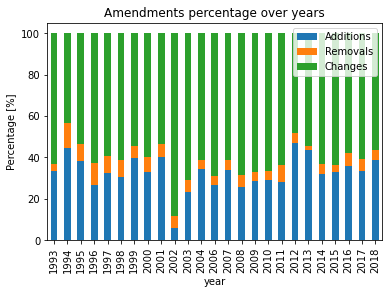

In [5]:
ax = df_yearly[['perc_additions', 'perc_removals', 'perc_changes']].plot.bar(stacked=True)
ax.set_ylabel("Percentage [%]")
ax.legend(["Additions", "Removals", "Changes"])
ax.set_title("Amendments percentage over years");

## Count "ustawa"

In [6]:
def count_word(document: str) -> int:
    return len(re.findall(r"\bustaw([aąeęoy]|(ami)|(ie)|(ach))?\b", document, re.IGNORECASE))

def count_word_with_suffix(document: str) -> int:
    return len(re.findall(r"\bustaw([aąeęoy]|(ami)|(ie)|(ach))?\b\sz\sdnia\b", document, re.IGNORECASE))

def count_word_without_suffix(document: str) -> int:
    return len(re.findall(r"\bustaw([aąeęoy]|(ami)|(ie)|(ach))?\b(?!\sz\sdnia\b)", document, re.IGNORECASE))

In [7]:
df_word = process(count_word, count_word_with_suffix, count_word_without_suffix)
df_word.columns = ["name","cnt", "cnt_with_suffix", "cnt_without_suffix"]
df_word.head()

,name,cnt,cnt_with_suffix,cnt_without_suffix
0,2004_1693.txt,268,96,172
1,2004_2426.txt,15,2,13
2,2003_1511.txt,8,3,5
3,2000_1189.txt,4,2,2
4,2000_1010.txt,5,2,3


In [8]:
assert (df_word['cnt_with_suffix'] + df_word['cnt_without_suffix'] == df_word['cnt']).all()

In [9]:
def count_word_without_suffix_2(document: str) -> int:
    return len(re.findall(r"\bustaw([aąeęoy]|(ami)|(ie)|(ach))?\b(?!\so\szmianie\b)", document, re.IGNORECASE))

In [10]:
df_word_without_suffix = process(count_word_without_suffix_2)
df_word_without_suffix.columns = ["name", "cnt_without_suffix_2"]
df_word_without_suffix.head()

,name,cnt_without_suffix_2
0,2004_1693.txt,268
1,2004_2426.txt,15
2,2003_1511.txt,8
3,2000_1189.txt,4
4,2000_1010.txt,5


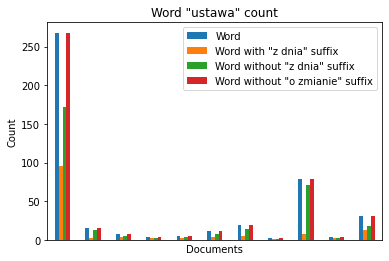

In [11]:
df_plot = pd.concat([df_word, df_word_without_suffix], axis=1)
ax = df_plot.loc[:10, ["cnt", "cnt_with_suffix", "cnt_without_suffix", "cnt_without_suffix_2"]].plot.bar()
ax.set_xticks([])
ax.set_xlabel("Documents")
ax.set_ylabel("Count")
ax.legend(["Word", 'Word with "z dnia" suffix', 'Word without "z dnia" suffix', 'Word without "o zmianie" suffix'])
ax.set_title('Word "ustawa" count');